In [14]:
# Importanweisungen

import numpy as num
import scipy as sci
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp 
unv=unp.nominal_values
usd=unp.std_devs

In [15]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12

In [16]:
# allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * num.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):

    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(num.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = num.array(error)
    return pfit_curvefit, perr_curvefit 

# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [17]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    f = open('data/%s.txt' % file, 'w')
    f.write(str(val).replace('/', ''))

In [18]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]
# Wasser eigenschaften: https://webbook.nist.gov/cgi/inchi/InChI%3D1S/H2O/h1H2
# https://www.engineeringtoolbox.com/water-thermal-properties-d_162.html

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin = 0gC
rho_water = 1 # g/ml
c_water = unc.ufloat(4.187, 0.01) # spez. waermekapazitaet wasser J / (g*K)
c_ice = unc.ufloat(2.108, 0.01) # " von EIS

In [19]:
# import der messwerte

unc_freq = 0.03 / num.sqrt(3) # digital etwa 0.03 Hz
unc_t20 = 1 / 20 / num.sqrt(3) # digital Abtastrate 20Hz
unc_t10 = 1 / 10 / num.sqrt(3) # digitale Abtastrate 10 Hz
unc_x = 0.0001 / num.sqrt(3) # digital Position
unc_react = 0.1 / num.sqrt(6) # analog abgeschaetzt 100 ms
unc_anzeige = 0.01 / num.sqrt(3) # digital stoppuhr 10 ms
unc_uhr = num.sqrt(unc_react**2 + unc_anzeige**2) # kombiniert fuer Stoppuhr
unc_vol50 = 1 / num.sqrt(6) # analog volumen 50 ml kolben in ml
unc_vol1 = 0.01 / num.sqrt(6) # analog volumen 1 ml pipette in ml
unc_temp = 0.1 / num.sqrt(3) # digital beide thermometer

con = {}
for i in range(0,50):
    con[i] = lambda s: float(s if len(s) > 0 else 0)

data = num.loadtxt("messung/reibung.txt", skiprows = 2, usecols = (0, 1, 2, 9), delimiter = "\t", converters = con)
fft = [unp.uarray(data[:,0], unc_freq), data[:,1]] # erste Spalte freq von FFT, zweite Spalte FFT Werte
reibung = [unp.uarray(data[:,2], unc_t20), unp.uarray(data[:, 3], unc_x)] # dritte Spalte Zeit der Messung in s, zehnte Spalte position in m

reibung = num.transpose(list(filter(lambda s: abs(s[1]) > 0.0001, num.transpose(reibung))))

data = num.loadtxt("messung/warm_machen.txt", skiprows = 2, usecols = (0, 10, 11, 21), delimiter = "\t", converters = con)
kalt = [unp.uarray(data[:,0], unc_t10), unp.uarray(data[:, 1], unc_temp)] # erste Spalte Zeit, zweite Spalte Temperatur Werte
warm = [unp.uarray(data[:,2], unc_t10), unp.uarray(data[:, 3], unc_temp)] # dritte Spalte Zeit, vierte Spalte Temperatur

kalt = num.transpose(list(filter(lambda s: abs(s[1]) > 0.0001, num.transpose(kalt))))
warm = num.transpose(list(filter(lambda s: abs(s[1]) > 0.0001, num.transpose(warm))))

f_FFT = unc.ufloat(3.09, unc_freq) # frequenz aus FFT ausgelesen bei 3.09
latex_printValue(f_FFT, "frequenz_FFT_Hz")

messbecher_vol = unc.ufloat(50, unc_vol50) # messbecher volumen in ml
messbecher_t = unc.ufloat(11.47, unc_uhr) # messbecher fuellzeit in s

reibung_Tzu = unc.ufloat(24.5, unc_temp) + K
reibung_Tab = unc.ufloat(25.0, unc_temp) + K

kalt_Tzu = unc.ufloat(25.3, unc_temp) + K
kalt_Tab = unc.ufloat(26.6, unc_temp) + K
kalt_TEnd = unc.ufloat(-26.7, unc_temp) + K

kalt_TvorSprung = unc.ufloat(-7.8, unc_temp) + K # temperatur vor dem SPrung
kalt_TnachSprung = unc.ufloat(0.4, unc_temp) + K # temperatur nach dem Sprung

warm_Tzu = unc.ufloat(25.5, unc_temp) + K
warm_Tab = unc.ufloat(25.5, unc_temp) + K
warm_TEnd = unc.ufloat(40.4, unc_temp) + K

probe_vol = unc.ufloat(1, unc_vol1) # pipette

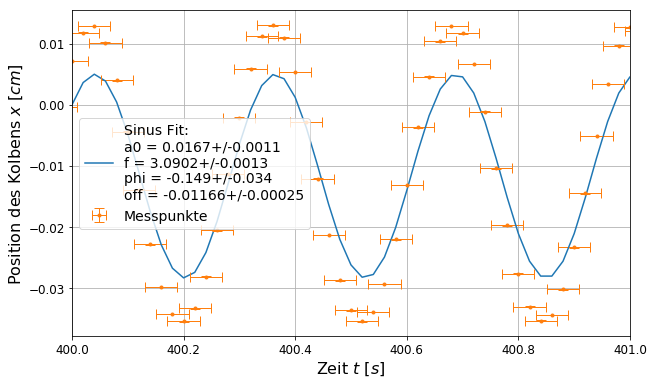

In [20]:
# diagramm: Position

fig=plt.figure(figsize=fig_size)

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 395 and s[0] <= 405, num.transpose(reibung))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), cyclicOff, yerr = usd(ydata), p0 = [0.02, 2 * math.pi * 3.0903, 0.7, -0.01165])
p = unp.uarray(pfit, perr)
p[1] /= 2 * math.pi
f_Fit = p[1] # gefittete Frequenz
latex_printValue(f_Fit, "frequenz_Fit_Hz")
plt.plot(unv(xdata), cyclicOff(unv(xdata), *pfit), label='Sinus Fit:\na0 = %s\nf = %s\nphi = %s\noff = %s' % tuple(p))

r = num.transpose(list(filter(lambda s: s[0] >= 399 and s[0] <= 402, num.transpose(reibung))))
plt.errorbar(unv(r[0]),unv(r[1]),usd(r[1]),usd(r[0]),fmt='.', capsize=5, linewidth=1, label='Messpunkte')

plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Position des Kolbens $x$ [$cm$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/Position.pdf")
plt.show()

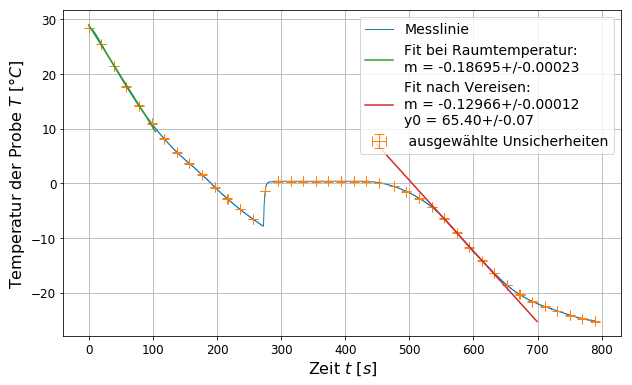

In [21]:
# diagramm: abkuehlen

fig=plt.figure(figsize=fig_size)


xdata, ydata = kalt
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = kalt[:, 0::196]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label=' ausgewählte Unsicherheiten')

xdata, ydata = num.transpose(list(filter(lambda s: s[1] >= 10 and s[1] <= 30, num.transpose(kalt))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [-0.1, 30])
p = unp.uarray(pfit, perr)
dT_kalt = p[0]
latex_printValue(dT_kalt, "dT_raumtemp_Ks-1")
plt.plot(unv(xdata), gerade(unv(xdata), *pfit), label='Fit bei Raumtemperatur:\nm = %s' % (p[0]))

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 550 and s[0] <= 630, num.transpose(kalt))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [-0.1, 30])
p = unp.uarray(pfit, perr)
dT_frier = p[0]
T0_frier = p[1]
plt.plot(num.arange(450, 700), gerade(num.arange(450, 700), *pfit), label='Fit nach Vereisen:\nm = %s\ny0 = %s' % tuple(p))

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/kalt_machen.pdf")
plt.show()

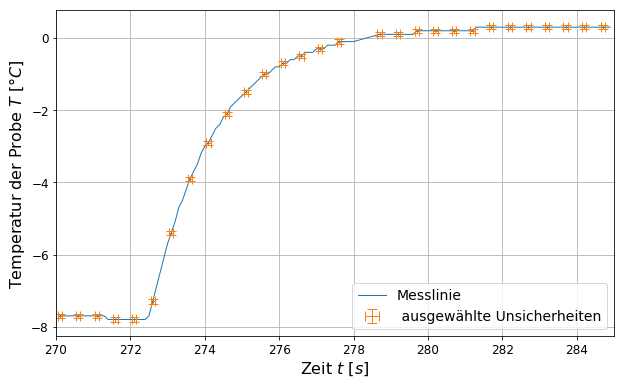

In [22]:
# diagramm: sprung

fig=plt.figure(figsize=fig_size)



xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 270 and s[0] <= 285, num.transpose(kalt))))
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 270 and s[0] <= 285, num.transpose(kalt))))[:, 0::5]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label=' ausgewählte Unsicherheiten')

kalt_tsprung = unc.ufloat(272.6, 5 * unc_t20)

plt.xlim(270,285)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/kalt_sprung.pdf")
plt.show()

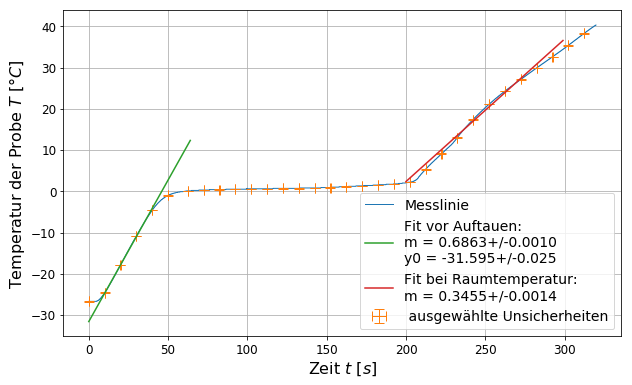

In [23]:
# diagramm: abkuehlen

fig=plt.figure(figsize=fig_size)

#pfit, perr = fit_curvefit(unv(xdata), unv(ydata), cyclicOff, yerr = usd(ydata), p0 = [0.02, 2 * math.pi * 3.0903, 0.7, -0.01165])
#p = unp.uarray(pfit, perr)
#p[1] /= 2 * math.pi
#f_Fit = p[1] # gefittete Frequenz
#latex_printValue(f_Fit, "frequenz_Fit_Hz")

xdata, ydata = warm
plt.plot(unv(xdata),unv(ydata), linewidth=1, label='Messlinie')

xdata, ydata = warm[:, 0::100]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label=' ausgewählte Unsicherheiten')

xdata, ydata = num.transpose(list(filter(lambda s: s[0] >= 10 and s[0] <= 40, num.transpose(warm))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [0.1, -30])
p = unp.uarray(pfit, perr)
dT_schmelz = p[0]
T0_schmelz = p[1]
plt.plot(num.arange(0, 65), gerade(num.arange(0, 65), *pfit), label='Fit vor Auftauen:\nm = %s\ny0 = %s' % tuple(p))

xdata, ydata = num.transpose(list(filter(lambda s: s[1] >= 10 and s[1] <= 30, num.transpose(warm))))
pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [0.1, -30])
p = unp.uarray(pfit, perr)
dT_warm = p[0]
plt.plot(num.arange(200, 300), gerade(num.arange(200, 300), *pfit), label='Fit bei Raumtemperatur:\nm = %s' % dT_warm)

warm_tsprung = unc.ufloat(200, 5/num.sqrt(6))

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Zeit $t$ [$s$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Temperatur der Probe $T$ [$°C$]", {'fontsize': fig_legendsize+2})
plt.savefig("data/warm_machen.pdf")
plt.show()

In [47]:
# Rechnung

durchfluss = rho_water * messbecher_vol / messbecher_t # g / s
Q_reibung = c_water * durchfluss * (reibung_Tzu - reibung_Tab) # J/s
latex_printValue(-Q_reibung, "arbeit_reibung_Js-1")
latex_printValue(-Q_reibung / f_Fit, "arbeit_reibung_JUmdrehung-1")

Q_kalt = c_water * durchfluss * (kalt_Tzu - kalt_Tab) # J/s
Q_warm = c_water * durchfluss * (warm_Tzu - warm_Tab) # J/s

dQ_kalt = c_water * rho_water * probe_vol * dT_kalt # J/s
dQ_warm = c_water * rho_water * probe_vol * dT_warm # J/s

W_kalt = dQ_kalt + Q_kalt + Q_reibung # J/s
W_warm = dQ_warm + Q_warm + Q_reibung # J/s

latex_printValue(-W_kalt, "arbeit_kalt_Js-1")
latex_printValue(-W_warm, "arbeit_warm_Js-1")
latex_printValue(-W_kalt/f_Fit, "arbeit_kalt_JUmdrehung-1")
latex_printValue(-W_warm/f_Fit, "arbeit_warm_JUmdrehung-1")

eps_kalt = abs(dQ_kalt / W_kalt)
eps_warm = abs(dQ_warm / W_warm)

latex_printValue(eps_kalt, "leistungszahl_kalt")
latex_printValue(eps_warm, "leistungszahl_warm")

t_frier = -T0_frier / dT_frier
t_schmelz = -T0_schmelz / dT_schmelz

DT_frier = t_frier - kalt_tsprung
DT_schmelz = warm_tsprung - t_schmelz

DQ_kaltSprung = c_water * rho_water * probe_vol * (kalt_TnachSprung - kalt_TvorSprung)
DQ_frier = -dQ_kalt * DT_frier + DQ_kaltSprung # Schmelzwaerme
DQ_schmelz = dQ_warm * DT_schmelz # Schmelzwaerme

latex_printValue(abs(DQ_frier), "schmelzwaerme_kalt_Jg-1")
latex_printValue(abs(DQ_frier), "schmelzwaerme_warm_Jg-1")

# kuehlleistung W = Q2 - Q1 + WR =dQ/s + WR/s
# dQ = c_p * rho * vol * dT
# Schmelzwaerme = 
#DQ_frier, DQ_schmelz, Q_reibung
#Q_kalt, Q_warm
eps_kalt, eps_warm

(0.02327165986060551+/-0.0014753623019539044,
 0.18835755668207832+/-0.05174704602643833)